In [34]:
!pip install meshwell==1.1.0
!pip show meshwell
# !pip uninstall meshwell

  Obtaining dependency information for meshwell==1.1.0 from https://files.pythonhosted.org/packages/b1/ff/904b0fecd63ec518b3c615a40b7b221f58008cd8704842411c49e397c65d/meshwell-1.1.0-py3-none-any.whl.metadata
  Attempting uninstall: meshwell
    Found existing installation: meshwell 1.2.0
    Uninstalling meshwell-1.2.0:
      Successfully uninstalled meshwell-1.2.0
Name: meshwell
Version: 1.1.0
Summary: GMSH wrapper, with integrated photonics focus
Home-page: 
Author: 
Author-email: Simon Bilodeau <sb30@princeton.edu>
License: 
Location: C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages
Requires: gmsh, meshio, pydantic, shapely, tqdm
Required-by: femwell


In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Can just generate any mesh to pass to femwell through meshwell 


In [36]:
import shapely
from meshwell.model import Model
from meshwell.polysurface import PolySurface
from skfem import Basis, ElementTriP0, Mesh
from skfem.io.meshio import from_meshio

from femwell.maxwell.waveguide import compute_modes
from femwell.visualization import plot_domains

RuntimeError: no validator found for <class 'shapely.geometry.polygon.Polygon'>, see `arbitrary_types_allowed` in Config

Text(0.5, 1.0, 'Silicon')

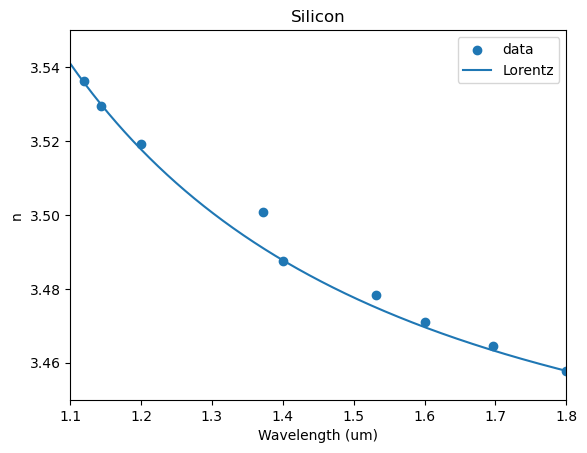

In [16]:
si_data = np.loadtxt("./reference_data/Palik/palik_silicon.txt", skiprows=1)
c = 299792458  # m/s


def ncore(wl):
    # Assume wl provided in um
    wl_m = wl * 1e-6
    eps = 7.9874
    eps_lorentz = 3.6880
    w0 = 3.9328e15
    return np.sqrt(eps + eps_lorentz * w0**2 / (w0**2 - (2 * np.pi * c / wl_m) ** 2))


wls = np.linspace(1.100, 1.800, 1000)

plt.scatter(si_data[:, 0] * 1e-3, si_data[:, 1], label="data")
plt.plot(wls, ncore(wls), label="Lorentz")
plt.xlim([1.100, 1.800])
plt.ylim([3.45, 3.55])
plt.xlabel("Wavelength (um)")
plt.ylabel("n")
plt.legend()
plt.title("Silicon")

In [17]:
def coupled_waveguides_crosstalk(
    width_A: float = 0.5,
    width_B: float = 0.5,
    gap: float = 1.0,
    thickness: float = 0.22,
    core_index: float = ncore(1.55),
    clad_index: float = 1.444,
    wavelength: float = 1.55,
    simulation_padding: float = 2.0,
    plot_geometry: bool = False,
    plot_modes: bool = False,
):
    # Define mesh
    waveguide_A_polygon = shapely.geometry.box(-width_A - gap / 2, 0, -gap / 2, thickness)
    waveguide_B_polygon = shapely.geometry.box(gap / 2, 0, width_B + gap / 2, thickness)
    cladding_polygon = shapely.geometry.box(
        -width_A / 2 - gap / 2 - simulation_padding,
        -simulation_padding,
        width_B / 2 + gap / 2 + simulation_padding,
        simulation_padding + thickness,
    )

    model = Model()

    waveguide_A = PolySurface(
        polygons=waveguide_A_polygon,
        model=model,
        physical_name="waveguide_A",
        resolution={"resolution": 0.05, "DistMax": 1.0, "SizeMax": 0.2},
        mesh_order=1,
    )
    waveguide_B = PolySurface(
        polygons=waveguide_B_polygon,
        model=model,
        physical_name="waveguide_B",
        resolution={"resolution": 0.05, "DistMax": 1.0, "SizeMax": 0.2},
        mesh_order=1,
    )
    cladding = PolySurface(
        polygons=cladding_polygon,
        model=model,
        physical_name="cladding",
        mesh_order=2,
    )

    mesh = from_meshio(
        model.mesh(
            entities_list=[waveguide_A, waveguide_B, cladding],
            filename="mesh.msh",
            default_characteristic_length=0.2,
        )
    )

    basis0 = Basis(mesh, ElementTriP0(), intorder=4)

    # Solve for mode A in isolation
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "waveguide_A": core_index,
        "waveguide_B": clad_index,
        "cladding": clad_index,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    if plot_geometry:
        mesh.draw().show()
        plt.show()
        plot_domains(mesh)
        plt.show()

        fig, axs = plt.subplots(1, 2)
        for ax in axs:
            ax.set_aspect(1)
        axs[0].set_title(r"$\Re\epsilon$, waveguide A")
        basis0.plot(epsilon.real, colorbar=True, ax=axs[0])
        axs[1].set_title(r"$\Im\epsilon$, waveguide A")
        basis0.plot(epsilon.imag, shading="gouraud", colorbar=True, ax=axs[1])
        plt.show()

    # Get modes
    modes_A = compute_modes(
        basis0,
        epsilon,
        wavelength=wavelength,
        num_modes=1,
        order=2,
        radius=np.inf,
    )
    beta_A = np.real(modes_A[0].n_eff) * 2 * np.pi / wavelength

    if plot_modes:
        modes_A[0].plot(modes_A[0].E.real, colorbar=True, direction="x")
        plt.show()

    # Solve for mode B in isolation
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "waveguide_A": clad_index,
        "waveguide_B": core_index,
        "cladding": clad_index,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    if plot_geometry:
        mesh.draw().show()
        plt.show()
        plot_domains(mesh)
        plt.show()

        fig, axs = plt.subplots(1, 2)
        for ax in axs:
            ax.set_aspect(1)
        axs[0].set_title(r"$\Re\epsilon$, waveguide B")
        basis0.plot(epsilon.real, colorbar=True, ax=axs[0])
        axs[1].set_title(r"$\Im\epsilon$, waveguide B")
        basis0.plot(epsilon.imag, shading="gouraud", colorbar=True, ax=axs[1])
        plt.show()

    # We do not need B in this formulation
    # modes_B = compute_modes(
    #     basis0,
    #     epsilon,
    #     wavelength=wavelength,
    #     num_modes=1,
    #     order=2,
    #     radius=np.inf,
    # )
    # beta_B = np.real(modes_B[0].n_eff) * 2 * np.pi / wavelength

    # if plot_modes:
    #     modes_B[0].plot(modes_B[0].E.real, colorbar=True, direction="x")
    #     plt.show()

    # Solve for hybrid modes
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "waveguide_A": core_index,
        "waveguide_B": core_index,
        "cladding": clad_index,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    if plot_geometry:
        mesh.draw().show()
        plt.show()
        plot_domains(mesh)
        plt.show()

        fig, axs = plt.subplots(1, 2)
        for ax in axs:
            ax.set_aspect(1)
        axs[0].set_title(r"$\Re\epsilon$, coupler")
        basis0.plot(epsilon.real, colorbar=True, ax=axs[0])
        axs[1].set_title(r"$\Im\epsilon$, coupler")
        basis0.plot(epsilon.imag, shading="gouraud", colorbar=True, ax=axs[1])
        plt.show()

    modes_full = compute_modes(
        basis0,
        epsilon,
        wavelength=wavelength,
        num_modes=2,
        order=2,
        radius=np.inf,
    )
    beta_full_1 = np.real(modes_full[0].n_eff) * 2 * np.pi / wavelength
    beta_full_2 = np.real(modes_full[1].n_eff) * 2 * np.pi / wavelength

    if plot_modes:
        modes_full[0].plot(modes_full[0].E.real, colorbar=True, direction="x")
        plt.show()
        modes_full[1].plot(modes_full[1].E.real, colorbar=True, direction="x")
        plt.show()

    # Overlap integrals
    A_into_1 = np.abs(modes_A[0].calculate_overlap(modes_full[0])) ** 2
    A_into_2 = np.abs(modes_A[0].calculate_overlap(modes_full[1])) ** 2

    coeff1 = np.sqrt(A_into_1) / np.sqrt(A_into_1 + A_into_2)  # normalize
    coeff2 = np.sqrt(A_into_2) / np.sqrt(A_into_1 + A_into_2)  # normalize

    # Worst case EME crosstalk calculation
    # Cross talk as defined in the book: 0 dB is full cross-talk
    # return 10*np.log10(1 - (np.abs(coeff1) ** 4 + np.abs(coeff2) ** 4 - 2 * np.abs(coeff1)**2 * np.abs(coeff2)**2))
    return coeff1, coeff2, beta_full_1, beta_full_2

In [18]:
def PA(coeff1, coeff2, beta_full_1, beta_full_2, L, wavelength=1.55):
    """Power in waveguide A vs propagation length"""
    return (
        np.abs(coeff1) ** 4
        + np.abs(coeff2) ** 4
        + 2 * np.abs(coeff1) ** 2 * np.abs(coeff2) ** 2 * np.cos((beta_full_2 - beta_full_1) * L)
    )


def PB(coeff1, coeff2, beta_full_1, beta_full_2, L):
    """Power in waveguide B vs propagation length"""
    return 1 - PA(coeff1, coeff2, beta_full_1, beta_full_2, L)


def dB(lin: float = 0.0):
    """Conversion to dB"""
    return 10 * np.log10(lin)

In [19]:
coeff1s = {}
coeff2s = {}
beta_full_1s = {}
beta_full_2s = {}

width_A = 0.5
widths_B = [0.4, 0.5]
gaps = [0.2, 0.4]

for width_B in widths_B:
    for gap in gaps:
        coeff1, coeff2, beta_full_1, beta_full_2 = coupled_waveguides_crosstalk(
            width_A=width_A,
            width_B=width_B,
            gap=gap,
            thickness=0.22,
            core_index=3.48,
            clad_index=1.44,
            wavelength=1.55,
            simulation_padding=3.0,
            plot_geometry=True,
            plot_modes=True,
        )

        coeff1s[(width_B, gap)] = coeff1
        coeff2s[(width_B, gap)] = coeff2
        beta_full_1s[(width_B, gap)] = beta_full_1
        beta_full_2s[(width_B, gap)] = beta_full_2

NameError: name 'PolySurface' is not defined